In [16]:

import os
import socket
import time
import traceback
import numpy as np
from colorama import init
from multiprocessing import Process, Pipe
init()
def get_files_to_read(base_path):
    starting_file_index = -1
    ending_file_index = -1
    pointer = 0
    while True:
        es = os.path.exists(base_path+'mcom_buffer_%d____starting_session.txt'%pointer)
        ee = os.path.exists(base_path+'mcom_buffer_%d.txt'%pointer)
        if (not es) and (not ee): break
        assert not (ee and es), ('?')
        if es: starting_file_index = pointer; ending_file_index = pointer
        if ee: ending_file_index = pointer
        pointer += 1
        assert pointer < 1e3
    assert starting_file_index>=0 and ending_file_index>=0, ('查找日志失败:', base_path)

    file_path = []
    for i in range(starting_file_index, ending_file_index+1):
        if i==starting_file_index: file_path.append(base_path+'mcom_buffer_%d____starting_session.txt'%i)
        else: file_path.append(base_path+'mcom_buffer_%d.txt'%i)
        assert os.path.exists(file_path[0]), ('?')
    return file_path

def read_experiment(base_path):
    files_to_read = get_files_to_read(base_path)
    cmd_lines = []
    for file in files_to_read:
        f = open(file, 'r')
        lines = f.readlines()
        cmd_lines.extend(lines)
    dictionary = {}

    def rec(value,name): 
        if name not in dictionary:
            dictionary[name] = []
        dictionary[name].append(value)
        return

    for cmd_str in cmd_lines:
        if '>>' in cmd_str:
            cmd_str_ = cmd_str[2:].strip('\n')
            if not cmd_str_.startswith('rec('): continue
            eval('%s'%cmd_str_)
    return dictionary

def stack_cutlong(arr_list, min_len=None):
    if min_len is None:
        min_len = min([len(item) for item in arr_list])
    print([len(item) for item in arr_list],'\tselect:', min_len)
    return np.stack([item[:min_len] for item in arr_list])


def smooth(data, sm=1):
    if sm > 1:
        y = np.ones(sm)*1.0/sm
        d = np.convolve(y, data, 'valid')#"same")
    else:
        d = data
    return np.array(d)


def tsplot(ax, data, label, resize_x, smooth_sm=None, **kw):
    if smooth_sm is not None:
        print('警告 smooth_sm=',smooth_sm)
        data = smooth(data, smooth_sm)

    print('警告 resize_x=',resize_x)
    x = np.arange(data.shape[1])
    x = resize_x*x
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    ax.fill_between(x,cis[0],cis[1],alpha=0.4, **kw)
    ax.plot(x,est, linewidth=1.5, label=label, **kw)
    ax.margins(x=0)


In [17]:


party = [
    # {
    #     "Method": "AddBnAddAe",
    #     "path": [
    #         "ZHECKPOINT/pymarl-starcraft-original-addbn-addae-r1",
    #         "ZHECKPOINT/pymarl-starcraft-original-addbn-addae-r2",
    #         "ZHECKPOINT/pymarl-starcraft-original-addbn-addae-r3",
    #     ]
    # },

# ZHECKPOINT/pymarl-starcraft-sim-AddBn-r1
    {
        "Method": "AddBn",
        "path": [
            "ZHECKPOINT/pymarl-starcraft-sim-AddBn-r1",
            "ZHECKPOINT/pymarl-starcraft-sim-AddBn-r2",
            "ZHECKPOINT/pymarl-starcraft-sim-AddBn-r3",
        ]
    },

    {
        "Method": "Original",
        "path": [
            "ZHECKPOINT/pymarl-starcraft-sim-original-r1",
            "ZHECKPOINT/pymarl-starcraft-sim-original-r2",
            "ZHECKPOINT/pymarl-starcraft-sim-original-r3",
        ]
    },
]
for ex in party:
    for i, path in enumerate(ex['path']):
        ex['path'][i] = '../' + ex['path'][i] + '/logger/'

In [21]:
# smooth_sm = 4
# main_key = 'reward'
# main_key_name_on_graph = 'Mean Episode Rewards'
# drop_data = 50 #None # 5


smooth_sm = 1
main_key = 'test-win-rate'
main_key_name_on_graph = 'Test Win Rate'
drop_data = 1 #None # 5

max_raw_x = {
}
# drop_data = 50 #None # 5
# drop_data = 500 #None # 5

In [22]:
samples = []

for ex in party:
    pathes = ex['path']
    for path in pathes:
        ex['readings of %s'%path] = read_experiment(path)
        print('readings of %s'%path)

def shift_x(x):
    return x* 8

for ex in party:
    # ex_ydata_batch = []
    for path in ex['path']:
        ydata = ex['readings of %s'%path][main_key]
        ydata = np.array(ydata)
        if smooth_sm is not None:
            ydata = smooth(ydata, smooth_sm); print('警告 平滑系数smooth_sm=',smooth_sm)
        for x, y in enumerate(ydata):
            if (drop_data is not None) and (not x%drop_data==0): continue
            if (ex['Method'] in max_raw_x) and (x > max_raw_x[ex['Method']]): continue
            samples.append({
                'Training Episodes':shift_x(x),
                main_key_name_on_graph: y,
                # 'color':party[exp_name]['color'],
                'Method':ex['Method'],
            })                

readings of ../ZHECKPOINT/pymarl-starcraft-sim-AddBn-r1/logger/
readings of ../ZHECKPOINT/pymarl-starcraft-sim-AddBn-r2/logger/
readings of ../ZHECKPOINT/pymarl-starcraft-sim-AddBn-r3/logger/
readings of ../ZHECKPOINT/pymarl-starcraft-sim-original-r1/logger/
readings of ../ZHECKPOINT/pymarl-starcraft-sim-original-r2/logger/
readings of ../ZHECKPOINT/pymarl-starcraft-sim-original-r3/logger/
警告 平滑系数smooth_sm= 1
警告 平滑系数smooth_sm= 1
警告 平滑系数smooth_sm= 1
警告 平滑系数smooth_sm= 1
警告 平滑系数smooth_sm= 1
警告 平滑系数smooth_sm= 1


<ipython-input-23-505f44716fa5>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)


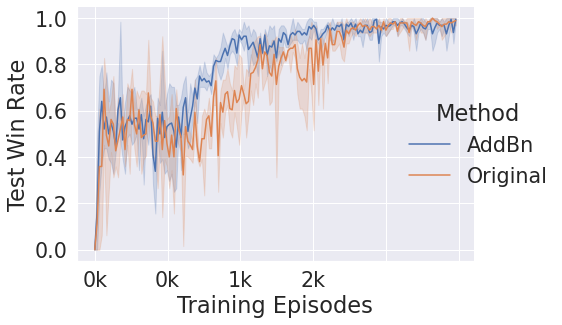

read finish!


In [23]:
%matplotlib inline
import pandas as pd
pd_sample = pd.DataFrame(samples)

import seaborn as sns
import matplotlib
# matplotlib.use('Agg')
# import matplotlib.pyplot as plt;  plt.rc('font',family='Times New Roman');
import matplotlib.pyplot as plt

# plt.ioff()
#设置风格、尺度

sns.set_style('darkgrid')
sns.set_context('paper', font_scale=2.5)
# plt.rc({
#     'text.latex.unicode': True,
#     })
sns.set(font="Times New Roman", font_scale=1.88)
# sns.set(font="Verdana")
res = sns.relplot(data=pd_sample, x='Training Episodes', y=main_key_name_on_graph, hue="Method", kind="line")
# sns.lineplot(data=pd_sample, x='Training Episodes', y='Mean Episode Rewards', hue="Method")
for ax in res.fig.axes:
    xlabels = ['{:,.0f}'.format(x) + 'k' for x in ax.get_xticks()/1000]
    ax.set_xticklabels(xlabels)

sns.move_legend(
    res, "center left",
    bbox_to_anchor=(0.79, 0.55)
)
# sns.move_legend(ax, "upper right", bbox_to_anchor=(1, 1))



plt.tight_layout(); 
# plt.savefig(
#     './保存图像/IMG-1-1-new-seaborn_relplot.pdf',
#     # bbox_inches='tight'
#     )
# plt.tight_layout(); 
plt.show()
print('read finish!')